In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import sklearn.metrics
import time

import faiss  # KNN testing - python 3.5 only?
from scipy.stats import mode

import matplotlib.pyplot as plt 

from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

In [2]:


os_dir = os.path.abspath('')
os_dir_data = os.path.join(os_dir, r"data/original/")

test_csv_path = os_dir_data + "1000_test.csv"
train_csv_path = os_dir_data + "1000_train.csv"

header_list = ["# label","f0","f1","f2","f3","f4","f5","f6","f7","f8","f9","f10","f11","f12","f13","f14","f15","f16","f17","f18","f19","f20","f21","f22","f23","f24","f25","f26"]

test_df = pd.read_csv(test_csv_path, names=header_list, skiprows=[0])  # skip row 0 because we are creating our own header
train_df = pd.read_csv(train_csv_path, names=header_list, skiprows=[0])  # skip row 0 because we are creating our own header


In [3]:
print(test_df.shape)
print(train_df.shape)

####### scale data

df_columns = list(test_df.columns)

df_columns_features = df_columns
df_columns_label = df_columns[0]
df_columns_features.pop(0)


print(df_columns_features)
print(type(df_columns_features))

#scaler = StandardScaler()
#scaler = MinMaxScaler()
# test_df[df_columns_features] = scaler.fit_transform(test_df[df_columns_features])
# train_df[df_columns_features] = scaler.fit_transform(train_df[df_columns_features])

####### end scale data

(3500000, 28)
(7000000, 28)
['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26']
<class 'list'>


In [4]:
n_samples = 3500000  # 200000

####### Separate the label from the normal dataframe

train_df = train_df[train_df["f24"] > -20]

test_subsample_df = test_df.sample(n=n_samples, random_state=1)
train_subsample_df = train_df.sample(n=n_samples*2 - 1, random_state=1)

test_subsample_label_arr = np.array(test_subsample_df[df_columns_label])
test_subsample_df = test_subsample_df.drop(columns=df_columns_label)

train_subsample_label_arr = np.array(train_subsample_df[df_columns_label])
train_subsample_df = train_subsample_df.drop(columns=df_columns_label)
#######

print(train_subsample_df.shape)


###### Perform PCA on the subsample (if desired)
do_perform_pca = False
if do_perform_pca:
    pca = PCA(.95, random_state=1)

    pca.fit(train_subsample_df)  # fit pca on training set

    print(f"Total shape: {len(train_subsample_df.columns)}, PCA Component count: {pca.components_.shape}")

    # transform the test and train
    train_subsample_df = pca.transform(train_subsample_df)
    test_subsample_df = pca.transform(test_subsample_df)

(6999999, 27)


In [5]:
#scaler = StandardScaler()
scaler = MinMaxScaler()
train_subsample_df[df_columns_features] = scaler.fit_transform(train_subsample_df[df_columns_features])


{'relu': {(8,): None}}
On: relu | (8,)
Time: [635.5047430992126]
AUC: 0.959020226127675
{'relu': {(8,): 0.959020226127675}}
[0.959020226127675]
[635.5047430992126]


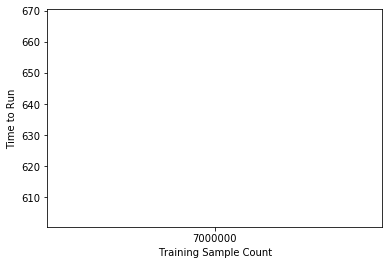

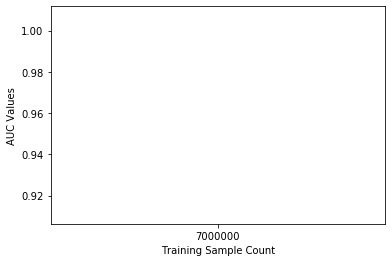

In [6]:
# Each element in the tuple represents the number of nodes at the ith position where i is the index of the tuple. Thus the length of tuple denotes the total number of hidden layers in the network.
# 200k samples + hidden_layer_sizes=(100,) + adam = 97.07 AUC (10,10,10) hidden layer gives same AUC too
# 3.5m samples + hidden_layer_sizes=(100,) + adam = 97.36 AUC (24m to run)

# TODO:
# try testing various parameters (activation, hidden layer). Use for loops to iterate through a ton and report the best results.
# try verbose output to see if the max_iter is reached or if tol is achieved?
activation_states = ["logistic", "tanh", "relu"]  # identity has very poor performance
activation_states = ["relu"]

#hidden_layer_states = [(20,10,5),(10,5), (100,),(5,2),(60,30,15),(40,20,10),(4,2),(20,10)]  # v1
#hidden_layer_states = [(20,10,5),(100,),(60,30,15),(40,20,10), (10,), (5,), (20,), (40,), (100,10)]
hidden_layer_states = [(20,10,5),(100,),(60,30,15),(40,20,10), (40,), (100,10)]
hidden_layer_states = [(8,)]


#n_samples_arr = [100000,500000,1000000,1500000,2000000,2500000, 3000000,3500000]
n_samples_arr = [3500000]
n_samples_arr = np.array(n_samples_arr)

# 3 layers all out perform 2 layers? 1 layer (100,) did well.

report_LR_roc_auc_dict = dict.fromkeys(activation_states)
for keys, vals in report_LR_roc_auc_dict.items():
    report_LR_roc_auc_dict[keys] = dict.fromkeys(hidden_layer_states)

print(report_LR_roc_auc_dict)
# batch_size_arr = [25, 50, 75, 100, 125, 150, 175, 200]
auc_arr = []
NN_time_arr = []
for activations in activation_states:
    for hiddens_layers in hidden_layer_states:

        # ####### Separate the label from the normal dataframe

        # test_subsample_df = test_df.sample(n=n_samples, random_state=1)
        # train_subsample_df = train_df.sample(n=n_samples*2, random_state=1)

        # test_subsample_label_arr = np.array(test_subsample_df[df_columns_label])
        # test_subsample_df = test_subsample_df.drop(columns=df_columns_label)

        # train_subsample_label_arr = np.array(train_subsample_df[df_columns_label])
        # train_subsample_df = train_subsample_df.drop(columns=df_columns_label)
        # #######

        print(f"On: {activations} | {hiddens_layers}")

        time_start = time.time()
        
        # batch_size = 1 means no batch size
        clf_NN = MLPClassifier(alpha=1e-5, hidden_layer_sizes=hiddens_layers, activation=activations, batch_size=200, random_state=1, solver="adam")   # "adam SGD solver better than lbfgs". Adam MUCH faster than SGD. (200k samples is ~25 sec for adam, 60 sec for SGD with same accuracy)
        clf_NN.fit(train_subsample_df, train_subsample_label_arr)
        pred_labels = np.array(clf_NN.predict(test_subsample_df))

        report_LR = sklearn.metrics.classification_report(y_true = test_subsample_label_arr, y_pred = pred_labels, digits=4)
        report_LR_roc_auc = sklearn.metrics.roc_auc_score(y_true = test_subsample_label_arr, y_score=clf_NN.predict_proba(test_subsample_df)[:,1])
        report_LR_roc_auc_dict[activations][hiddens_layers] = report_LR_roc_auc

        auc_arr.append(report_LR_roc_auc)
        NN_time_arr.append(time.time() - time_start)
        print(f"Time: {NN_time_arr}")
        print(f"AUC: {report_LR_roc_auc}")
        # print(report_LR)
print(report_LR_roc_auc_dict)

print(auc_arr)
print(NN_time_arr)

# fig, ax = plt.subplots()

# ax.plot(batch_size_arr, auc_arr)
# plt.xlabel('Batch Size')
# plt.ylabel('AUC Values')
# ax.set_xticks(batch_size_arr)
# plt.show()

fig, ax = plt.subplots()
ax.plot(n_samples_arr*2, NN_time_arr)
plt.xlabel('Training Sample Count')
plt.ylabel('Time to Run')
ax.set_xticks(n_samples_arr*2)
plt.show()

fig, ax = plt.subplots()
ax.plot(n_samples_arr*2, auc_arr)
plt.xlabel('Training Sample Count')
plt.ylabel('AUC Values')
ax.set_xticks(n_samples_arr*2)
plt.show()

In [6]:
# Each element in the tuple represents the number of nodes at the ith position where i is the index of the tuple. Thus the length of tuple denotes the total number of hidden layers in the network.
# 200k samples + hidden_layer_sizes=(100,) + adam = 97.07 AUC (10,10,10) hidden layer gives same AUC too
# 3.5m samples + hidden_layer_sizes=(100,) + adam = 97.36 AUC (24m to run)

# TODO:
# try testing various parameters (activation, hidden layer). Use for loops to iterate through a ton and report the best results.
# try verbose output to see if the max_iter is reached or if tol is achieved?
activation_states = ["logistic", "tanh", "relu"]  # identity has very poor performance
activation_states = ["relu"]

#hidden_layer_states = [(20,10,5),(10,5), (100,),(5,2),(60,30,15),(40,20,10),(4,2),(20,10)]  # v1
#hidden_layer_states = [(20,10,5),(100,),(60,30,15),(40,20,10), (10,), (5,), (20,), (40,), (100,10)]
#hidden_layer_states = [(20,10,5),(100,),(60,30,15),(40,20,10), (40,), (100,10), (14,), (14,8,5),(14,8,5,3), (80,60,40,20), (100, 50, 25), (100,80,60,40,20), (80,40,20,10), (40,30,20,10),(14,8),(14,10,6), (20,15,10,5),(10,5), (8,4), (30,15), (20,10), (20,), (8,),(20,15),(25,15),(80,40),(60,40), (60,30),(45,30)]
#hidden_layer_states = [(40,20,10)]  # best?

#hidden_layer_states = [(140,120,100,80,60), (160,120,80,40),(160,80,40,20),(160,80,40,20,10), (180,160,140,120,100),(180,160,140,120,100,50,25),(200,100,50,25),(200,150,100,50),(300,200,100,50,20), (500,400,300,200,100,50,20),(200,100,50),(150,100,50)]
hidden_layer_states = [(40,20,10)]

n_samples_arr = [100000,500000,1000000,1500000,2000000,2500000, 3000000,3500000]
# n_samples_arr = [10000,20000,30000]
n_samples_arr = np.array(n_samples_arr)

# 3 layers all out perform 2 layers? 1 layer (100,) did well.

report_LR_roc_auc_dict = dict.fromkeys(hidden_layer_states)
print(report_LR_roc_auc_dict)
# batch_size_arr = [25, 50, 75, 100, 125, 150, 175, 200]
auc_arr = []
NN_time_arr = []

for hidden_layers in hidden_layer_states:

    ####### Separate the label from the normal dataframe

    test_subsample_df = test_df.sample(n=n_samples, random_state=1)
    train_subsample_df = train_df.sample(n=n_samples*2, random_state=1)

    test_subsample_label_arr = np.array(test_subsample_df[df_columns_label])
    test_subsample_df = test_subsample_df.drop(columns=df_columns_label)

    train_subsample_label_arr = np.array(train_subsample_df[df_columns_label])
    train_subsample_df = train_subsample_df.drop(columns=df_columns_label)
    #######

    print(f"On: {hidden_layers}")

    time_start = time.time()
    
    # batch_size = 1 means no batch size
    clf_NN = MLPClassifier(alpha=1e-5, hidden_layer_sizes=hidden_layers, activation="relu", batch_size=200, random_state=1, solver="adam")   # "adam SGD solver better than lbfgs". Adam MUCH faster than SGD. (200k samples is ~25 sec for adam, 60 sec for SGD with same accuracy)
    clf_NN.fit(train_subsample_df, train_subsample_label_arr)
    pred_labels = np.array(clf_NN.predict(test_subsample_df))

    report_LR = sklearn.metrics.classification_report(y_true = test_subsample_label_arr, y_pred = pred_labels, digits=4)
    report_LR_roc_auc = sklearn.metrics.roc_auc_score(y_true = test_subsample_label_arr, y_score=clf_NN.predict_proba(test_subsample_df)[:,1])
    report_LR_roc_auc_dict[hidden_layers] = report_LR_roc_auc

    auc_arr.append(report_LR_roc_auc)
    NN_time_arr.append(time.time() - time_start)
    print(f"Time: {NN_time_arr}")
    print(f"AUC: {report_LR_roc_auc}")
    # print(report_LR)
print(report_LR_roc_auc_dict)

print(auc_arr)
print(NN_time_arr)

# fig, ax = plt.subplots()

# ax.plot(batch_size_arr, auc_arr)
# plt.xlabel('Batch Size')
# plt.ylabel('AUC Values')
# ax.set_xticks(batch_size_arr)
# plt.show()

# fig, ax = plt.subplots()
# ax.plot(n_samples_arr*2, NN_time_arr)
# plt.xlabel('Training Sample Count')
# plt.ylabel('Time to Run')
# ax.set_xticks(n_samples_arr*2)
# plt.show()

# fig, ax = plt.subplots()
# ax.plot(n_samples_arr*2, auc_arr)
# plt.xlabel('Training Sample Count')
# plt.ylabel('AUC Values')
# ax.set_xticks(n_samples_arr*2)
# plt.show()

{(80, 60, 40, 20): None}
On: (80, 60, 40, 20)
Time: [3050.5275061130524]
AUC: 0.9762754601839736
{(80, 60, 40, 20): 0.9762754601839736}
[0.9762754601839736]
[3050.5275061130524]


{'logistic': {(40, 20, 10): None}, 'tanh': {(40, 20, 10): None}, 'relu': {(40, 20, 10): None}}
On: logistic
Time: [1321.0349984169006]
AUC: 0.9747374984106915
On: tanh
Time: [1321.0349984169006, 1173.9717772006989]
AUC: 0.9743537777518407
On: relu
Time: [1321.0349984169006, 1173.9717772006989, 1219.351223707199]
AUC: 0.9749019523810565
[0.9747374984106915, 0.9743537777518407, 0.9749019523810565]
[1321.0349984169006, 1173.9717772006989, 1219.351223707199]


ValueError: x and y must have same first dimension, but have shapes (8,) and (3,)

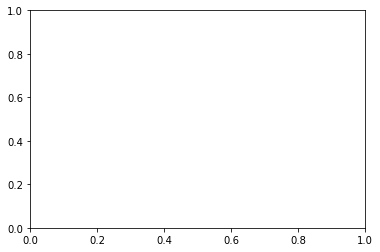

In [7]:
# activations table

# TODO:
# try testing various parameters (activation, hidden layer). Use for loops to iterate through a ton and report the best results.
# try verbose output to see if the max_iter is reached or if tol is achieved?
activation_states = ["logistic", "tanh", "relu"]  # identity has very poor performance
#activation_states = ["relu"]

#hidden_layer_states = [(20,10,5),(10,5), (100,),(5,2),(60,30,15),(40,20,10),(4,2),(20,10)]  # v1
#hidden_layer_states = [(20,10,5),(100,),(60,30,15),(40,20,10), (10,), (5,), (20,), (40,), (100,10)]
hidden_layer_states = [(20,10,5),(100,),(60,30,15),(40,20,10), (40,), (100,10)]
hidden_layer_states = [(40,20,10)]


n_samples_arr = [100000,500000,1000000,1500000,2000000,2500000, 3000000,3500000]
# n_samples_arr = [10000,20000,30000]
n_samples_arr = np.array(n_samples_arr)

# 3 layers all out perform 2 layers? 1 layer (100,) did well.

report_LR_roc_auc_dict = dict.fromkeys(activation_states)
for keys, vals in report_LR_roc_auc_dict.items():
    report_LR_roc_auc_dict[keys] = dict.fromkeys(hidden_layer_states)

print(report_LR_roc_auc_dict)
# batch_size_arr = [25, 50, 75, 100, 125, 150, 175, 200]
auc_arr = []
NN_time_arr = []

# solver_arr = ["adam", "sgd", "lbfgs"]
for activations in activation_states:

    ####### Separate the label from the normal dataframe

    test_subsample_df = test_df.sample(n=n_samples, random_state=1)
    train_subsample_df = train_df.sample(n=n_samples*2, random_state=1)

    test_subsample_label_arr = np.array(test_subsample_df[df_columns_label])
    test_subsample_df = test_subsample_df.drop(columns=df_columns_label)

    train_subsample_label_arr = np.array(train_subsample_df[df_columns_label])
    train_subsample_df = train_subsample_df.drop(columns=df_columns_label)
    #######

    print(f"On: {activations}")

    time_start = time.time()
    
    # batch_size = 1 means no batch size
    clf_NN = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(40,20,10), activation=activations, batch_size=200, random_state=1, solver="adam")   # "adam SGD solver better than lbfgs". Adam MUCH faster than SGD. (200k samples is ~25 sec for adam, 60 sec for SGD with same accuracy)
    clf_NN.fit(train_subsample_df, train_subsample_label_arr)
    pred_labels = np.array(clf_NN.predict(test_subsample_df))

    report_LR = sklearn.metrics.classification_report(y_true = test_subsample_label_arr, y_pred = pred_labels, digits=4)
    report_LR_roc_auc = sklearn.metrics.roc_auc_score(y_true = test_subsample_label_arr, y_score=clf_NN.predict_proba(test_subsample_df)[:,1])
    # report_LR_roc_auc_dict[activations][hiddens_layers] = report_LR_roc_auc

    auc_arr.append(report_LR_roc_auc)
    NN_time_arr.append(time.time() - time_start)
    print(f"Time: {NN_time_arr}")
    print(f"AUC: {report_LR_roc_auc}")
    # print(report_LR)
# print(report_LR_roc_auc_dict)

print(auc_arr)
print(NN_time_arr)

# fig, ax = plt.subplots()

# ax.plot(batch_size_arr, auc_arr)
# plt.xlabel('Batch Size')
# plt.ylabel('AUC Values')
# ax.set_xticks(batch_size_arr)
# plt.show()

fig, ax = plt.subplots()
ax.plot(n_samples_arr*2, NN_time_arr)
plt.xlabel('Training Sample Count')
plt.ylabel('Time to Run')
ax.set_xticks(n_samples_arr*2)
plt.show()

fig, ax = plt.subplots()
ax.plot(n_samples_arr*2, auc_arr)
plt.xlabel('Training Sample Count')
plt.ylabel('AUC Values')
ax.set_xticks(n_samples_arr*2)
plt.show()

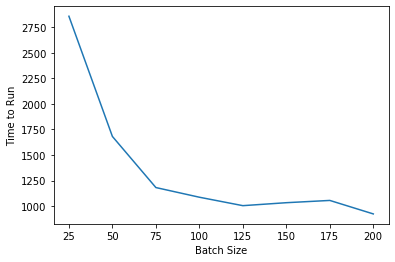

In [10]:
NN_time_arr = [2857.474167585373, 1681.279044866562, 1181.1645891666412, 1086.5500478744507, 1003.9881377220154, 1032.9491999149323, 1055.1552698612213, 923.1990578174591]

fig, ax = plt.subplots()
ax.plot(batch_size_arr, NN_time_arr)
plt.xlabel('Batch Size')
plt.ylabel('Time to Run')
ax.set_xticks(batch_size_arr)
plt.show()

adam solver is best?

3.5m sample tests:

batch size 200 + (40,20,10) + relu + standardscalar = 0.9747838795487936 (30m training)

batch size 200 + (40,20,10) + relu + MinMaxScaler (used in paper) = 0.9703224152026235

batch size 200 + (40,20,10) + relu + no scalar = 0.9749019523810565 (16m training)  ------------- best

batch size 100 + (40,20,10) + relu + no scalar = worse?